## RQ6: How can sentiment analysis of guest reviews for apartment-type Airbnb accommodations in London be used to forecast future demand and pricing trends? 

### Part II : Demand forecasting

In [31]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
from scipy import stats
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Download required NLTK data
nltk.download('vader_lexicon')
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/babyaimy/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/babyaimy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [32]:
# Load the datasets
language_custom_2 = pd.read_csv('spelling_corrected_reviews.csv')
listings_df = pd.read_csv('final_apartment_df.csv')

# Fix the column names
language_custom_2.rename(columns=lambda x: x.strip(), inplace=True)
listings_df.rename(columns=lambda x: x.strip(), inplace=True)

# Function to clean text and remove stop words
stop_words = set(stopwords.words('english'))
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lower case
    words = text.split()
    words = [word for word in words if word not in stop_words]  # Remove stop words
    return ' '.join(words)

# Apply text cleaning
language_custom_2['processed_comments'] = language_custom_2['comments'].apply(clean_text)

# Custom lexicon dictionary
custom_lexicon = {
    "good": 2.0,
    "bad": -2.0,
    "excellent": 3.0,
    "poor": -3.0,
    "amazing": 3.0,
    "awesome": 3.0,
    "fantastic": 3.0,
    "great": 2.5,
    "wonderful": 3.0,
    "love": 3.0,
    "perfect": 3.0,
    "superb": 3.0,
    "terrific": 3.0,
    "satisfactory": 1.5,
    "delightful": 2.5,
    "happy": 2.0,
    "pleased": 2.0,
    "excellent service": 3.5,
    "highly recommend": 3.5,
    "top-notch": 3.0,
    "terrible": -3.0,
    "awful": -3.0,
    "horrible": -3.0,
    "disgusting": -3.0,
    "hate": -3.0,
    "unacceptable": -2.5,
    "disappointing": -2.0,
    "poor service": -3.5,
    "not recommend": -3.0,
    "waste": -2.5,
    "regret": -2.5,
    "bad experience": -3.0,
    "never again": -3.0,
    "frustrating": -2.0,
    "worst": -3.0,
    "average": 0.0,
    "ok": 0.0,
    "mediocre": -0.5,
    "sufficient": 0.5,
    # Add more words/phrases as needed
}

# Function to update VADER lexicon
def update_vader_lexicon():
    vader_lexicon = SentimentIntensityAnalyzer().lexicon
    vader_lexicon.update(custom_lexicon)
    return SentimentIntensityAnalyzer()

# Initialize the updated VADER sentiment analyzer
sid = update_vader_lexicon()

# Function to classify comments as positive, negative, or neutral using VADER
def classify_sentiment_vader(text):
    score = sid.polarity_scores(text)
    if score['compound'] > 0.05:
        return 'positive'
    elif score['compound'] < -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply the sentiment analysis to the reviews DataFrame
language_custom_2['sentiment'] = language_custom_2['processed_comments'].apply(classify_sentiment_vader)

# Convert the 'date' column to datetime format
language_custom_2['date'] = pd.to_datetime(language_custom_2['date'])

# Set the 'date' column as the index
language_custom_2.set_index('date', inplace=True)

# Resample the data by month and count the number of reviews
monthly_reviews = language_custom_2.resample('ME').size()

# Display the aggregated data
monthly_reviews.head()

date
2010-12-31    1
2011-01-31    0
2011-02-28    0
2011-03-31    5
2011-04-30    4
Freq: ME, dtype: int64

## ARIMA forecasting model for demand

In [33]:
# Check if the time series is stationary using the Augmented Dickey-Fuller test
adf_test = adfuller(monthly_reviews)
adf_test_results = {
    'ADF Statistic': adf_test[0],
    'p-value': adf_test[1],
    'Critical Values': adf_test[4]
}
adf_test_results

{'ADF Statistic': -5.048640991297237,
 'p-value': 1.7765404184881826e-05,
 'Critical Values': {'1%': -3.476273058920005,
  '5%': -2.881687616548444,
  '10%': -2.5775132580261593}}

**The Augmented Dickey-Fuller (ADF) test results for the differenced series are as follows:**

- ADF Statistic: -5.048640991297237
- p-value: 1.7765404184881826e-05

**Critical Values:**
- 1%: -3.476273058920005
- 5%: -2.881687616548444
- 10%: -2.5775132580261593

Since the ADF statistic is less than the critical values and the p-value is much less than 0.05, we can reject the null hypothesis. This indicates that the series is now stationary.

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  160
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -922.074
Date:                Sun, 04 Aug 2024   AIC                           1850.148
Time:                        15:38:30   BIC                           1859.355
Sample:                    12-31-2010   HQIC                          1853.887
                         - 03-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9891      0.049    -20.093      0.000      -1.086      -0.893
ma.L1          0.8947      0.075     11.956      0.000       0.748       1.041
sigma2      6332.6935    374.452     16.912      0.0

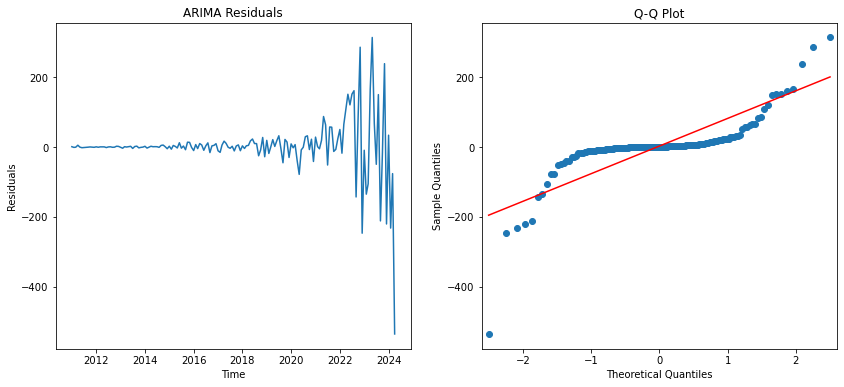

In [44]:
# Apply first-order differencing if the series is not stationary
if adf_test_results['p-value'] > 0.05:
    monthly_reviews_diff = monthly_reviews.diff().dropna()
    adf_test_diff = adfuller(monthly_reviews_diff)
    adf_test_diff_results = {
        'ADF Statistic': adf_test_diff[0],
        'p-value': adf_test_diff[1],
        'Critical Values': adf_test_diff[4]
    }
    print(adf_test_diff_results)
else:
    monthly_reviews_diff = monthly_reviews

# Fit the ARIMA model
model = ARIMA(monthly_reviews, order=(1, 1, 1))
model_fit = model.fit()

# Print the model summary
print(model_fit.summary())

# Plot the residuals
residuals = model_fit.resid
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Residuals plot
ax[0].plot(residuals)
ax[0].set_title('ARIMA Residuals')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Residuals')

# Q-Q plot
qqplot(residuals, line='s', ax=ax[1])
ax[1].set_title('Q-Q Plot')

plt.show()


    lb_stat  lb_pvalue
1  0.085678   0.769745
Types and dimensions:
forecast_mean type: <class 'numpy.ndarray'>, shape: (6,)
forecast_index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>, shape: (6,)
forecast_conf_int type: <class 'numpy.ndarray'>, shape: (6, 2)


/var/folders/yn/4vcq2czj6gd0jk1wttk_vj1h0000gn/T/ipykernel_10817/2270708597.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=monthly_reviews.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


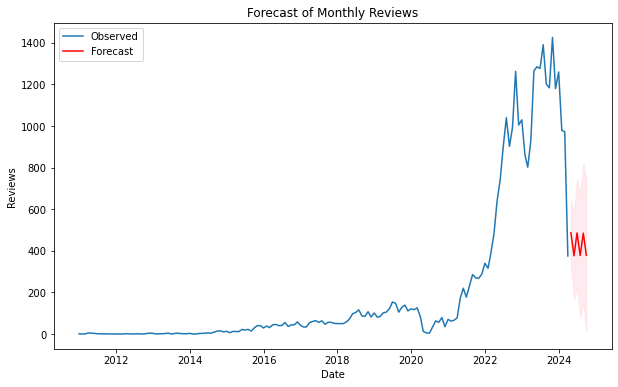

In [35]:
# Perform the Ljung-Box test
ljung_box_test = acorr_ljungbox(residuals, lags=[1], return_df=True)
print(ljung_box_test)

# Forecast the next 6 months
forecast_steps = 6
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=monthly_reviews.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='M')

# Get the forecasted mean and confidence intervals
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Ensure forecast mean and confidence intervals are numeric types
forecast_mean = forecast_mean.to_numpy()
forecast_conf_int = forecast_conf_int.to_numpy()

# Verify the types and dimensions
print("Types and dimensions:")
print(f"forecast_mean type: {type(forecast_mean)}, shape: {forecast_mean.shape}")
print(f"forecast_index type: {type(forecast_index)}, shape: {forecast_index.shape}")
print(f"forecast_conf_int type: {type(forecast_conf_int)}, shape: {forecast_conf_int.shape}")

# Ensure the forecast_index is a DatetimeIndex
if not isinstance(forecast_index, pd.DatetimeIndex):
    forecast_index = pd.DatetimeIndex(forecast_index)

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(monthly_reviews, label='Observed')
plt.plot(forecast_index.to_numpy(), forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_index.to_numpy(), 
                 forecast_conf_int[:, 0], 
                 forecast_conf_int[:, 1], 
                 color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Reviews')
plt.title('Forecast of Monthly Reviews')
plt.legend()
plt.show()


### ARIMA Model Summary and Residuals Analysis ###

**ARIMA Model Summary:**

1. Model Specification:

The model used is ARIMA(1, 1, 1), indicating:
AR(1): First-order autoregressive term.
I(1): First-order differencing to make the series stationary.
MA(1): First-order moving average term.

2. Coefficients:

ar.L1: The coefficient for the autoregressive term is -0.9891, which is highly significant (p-value = 0.000). This suggests that the previous period's value has a strong influence on the current period's value.
ma.L1: The coefficient for the moving average term is 0.8947, also highly significant (p-value = 0.000). This indicates that the model adjusts based on the lagged forecast errors.
sigma2: The variance of the residuals (error term) is 6332.6935, indicating the variability of the residuals.

3. Model Fit:

Log Likelihood: -922.074.
AIC: 1850.148 (Akaike Information Criterion).
BIC: 1859.355 (Bayesian Information Criterion).
These criteria help in model comparison; lower values generally indicate a better fit.

4. Diagnostic Tests:

- Ljung-Box Test:
Q(1): 0.09 with p-value 0.77, indicating that there is no significant autocorrelation in the residuals at lag 1.
- Jarque-Bera Test:
JB: 1701.03 with p-value 0.00, indicating that the residuals are not normally distributed.
- Heteroskedasticity (H):
H: 2348.18 with p-value 0.00, indicating heteroskedasticity in the residuals.
- Skew: -1.57, indicating the residuals are left-skewed.
- Kurtosis: 18.71, indicating a heavy-tailed distribution of residuals.

**Residuals Analysis:**

1. Residuals Plot:

The residuals plot shows the difference between the observed and fitted values over time. There is significant variability in the residuals, especially towards the end of the time series, which suggests that the model might not be capturing some aspects of the data well.

2. Q-Q Plot:

The Q-Q plot shows that the residuals deviate significantly from the theoretical normal distribution, particularly in the tails. This indicates non-normality in the residuals, which is also supported by the Jarque-Bera test result.

**Interpretation and Recommendations:**

1. Model Fit:

The ARIMA(1,1,1) model has a reasonable fit, as indicated by significant coefficients for both AR and MA terms. However, the high values of AIC and BIC suggest that there might be room for improvement.

2. Residuals Diagnostics:

The Ljung-Box test suggests no significant autocorrelation in residuals at lag 1, which is good.
However, the Jarque-Bera test indicates that the residuals are not normally distributed, and the Q-Q plot confirms this non-normality.
The presence of heteroskedasticity suggests that the variance of residuals is not constant over time, which might affect the model's predictive performance.


In [36]:
# Convert 'sentiment' to numerical scores: positive=1, neutral=0, negative=-1
sentiment_scores = language_custom_2['sentiment'].map({'positive': 1, 'neutral': 0, 'negative': -1})

# Combine sentiment scores with review dates
language_custom_2['sentiment_score'] = sentiment_scores

# Aggregate sentiment scores by month
monthly_sentiment_scores = language_custom_2['sentiment_score'].resample('ME').mean()

# Combine review counts and sentiment scores into a single DataFrame
combined_df = pd.DataFrame({
    'review_count': monthly_reviews,
    'sentiment_score': monthly_sentiment_scores
}).dropna()

print(combined_df.head())

            review_count  sentiment_score
date                                     
2010-12-31             1              1.0
2011-03-31             5              1.0
2011-04-30             4              1.0
2011-05-31             3              1.0
2011-06-30             1              1.0


## SARIMAX forecasting model in demand


It seems the ARIMA model forecast does not directly incorporate sentiment analysis. The ARIMA model was applied to the monthly count of reviews to forecast future review counts, but the sentiment of those reviews was not directly used in the forecasting model.

Use a multivariate time series forecasting model, like SARIMAX, which can incorporate exogenous variables (e.g., sentiment scores).

**In this approach:**

- Sentiment scores are aggregated and combined with review counts.
- A SARIMAX model is used to incorporate sentiment scores as exogenous variables.
- The forecast reflects both historical review counts and sentiment trends.

In [37]:
# Check if the time series is stationary using the Augmented Dickey-Fuller test
adf_test = adfuller(monthly_reviews)
adf_test_results = {
    'ADF Statistic': adf_test[0],
    'p-value': adf_test[1],
    'Critical Values': adf_test[4]
}
print(adf_test_results)

# Apply first-order differencing if the series is not stationary
if adf_test_results['p-value'] > 0.05:
    monthly_reviews_diff = monthly_reviews.diff().dropna()
    adf_test_diff = adfuller(monthly_reviews_diff)
    adf_test_diff_results = {
        'ADF Statistic': adf_test_diff[0],
        'p-value': adf_test_diff[1],
        'Critical Values': adf_test_diff[4]
    }
    print(adf_test_diff_results)
else:
    monthly_reviews_diff = monthly_reviews

{'ADF Statistic': -5.048640991297237, 'p-value': 1.7765404184881826e-05, 'Critical Values': {'1%': -3.476273058920005, '5%': -2.881687616548444, '10%': -2.5775132580261593}}


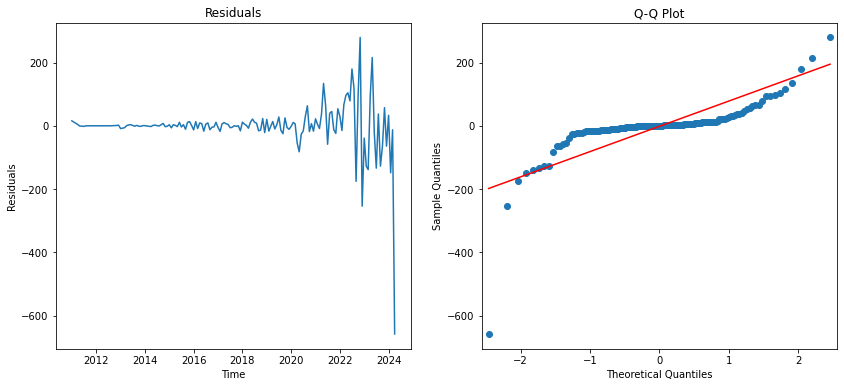

    lb_stat  lb_pvalue
1  0.089758   0.764485


In [27]:
# Plot the residuals
residuals = sarimax_fit.resid
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Residuals plot
ax[0].plot(residuals)
ax[0].set_title('Residuals')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Residuals')

# Q-Q plot
qqplot(residuals, line='s', ax=ax[1])
ax[1].set_title('Q-Q Plot')

plt.show()

# Perform the Ljung-Box test
ljung_box_test = acorr_ljungbox(residuals, lags=[1], return_df=True)
print(ljung_box_test)

### [1]  SARIMAX model 

    lb_stat  lb_pvalue
1  0.085678   0.769745
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.35350D+00    |proj g|=  7.67269D-03

At iterate    5    f=  5.34343D+00    |proj g|=  2.95349D-03


/var/folders/yn/4vcq2czj6gd0jk1wttk_vj1h0000gn/T/ipykernel_10817/1915136624.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sentiment_scores = language_custom_2['sentiment_score'].resample('M').mean()
/Users/babyaimy/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/babyaimy/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  5.33437D+00    |proj g|=  7.24918D-03

At iterate   15    f=  5.33016D+00    |proj g|=  7.98909D-03

At iterate   20    f=  5.32848D+00    |proj g|=  9.84475D-04

At iterate   25    f=  5.32804D+00    |proj g|=  2.26870D-03

At iterate   30    f=  5.32798D+00    |proj g|=  7.45847D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     44      1     0     0   4.363D-06   5.328D+00
  F =   5.3279794044192856     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                     SARIMAX Results                                      
Dep. Variable:        

/Users/babyaimy/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/var/folders/yn/4vcq2czj6gd0jk1wttk_vj1h0000gn/T/ipykernel_10817/1915136624.py:39: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=combined_df.index[-1], periods=forecast_steps + 1, freq='M')[1:]


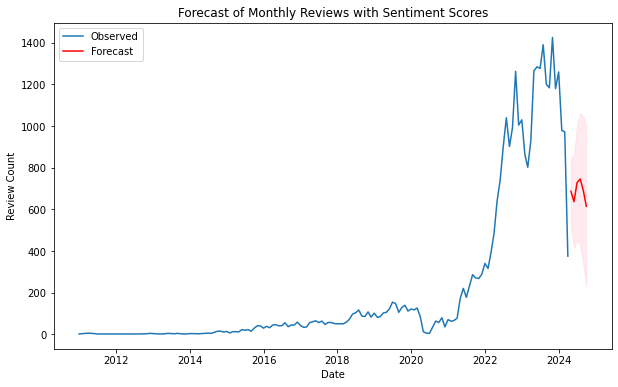

In [38]:
# Perform the Ljung-Box test
ljung_box_test = acorr_ljungbox(residuals, lags=[1], return_df=True)
print(ljung_box_test)

# Aggregate sentiment scores by month
sentiment_scores = language_custom_2['sentiment'].map({'positive': 1, 'neutral': 0, 'negative': -1})
language_custom_2['sentiment_score'] = sentiment_scores
monthly_sentiment_scores = language_custom_2['sentiment_score'].resample('M').mean()

# Combine review counts and sentiment scores into a single DataFrame
combined_df = pd.DataFrame({
    'review_count': monthly_reviews,
    'sentiment_score': monthly_sentiment_scores
}).dropna()

# Define the SARIMAX model
sarimax_model = SARIMAX(combined_df['review_count'], exog=combined_df['sentiment_score'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))

# Fit the model
sarimax_fit = sarimax_model.fit()

# Print the model summary
print(sarimax_fit.summary())

# Forecast the next 6 months
forecast_steps = 6
future_sentiment = combined_df['sentiment_score'].values[-1]  # Using last known sentiment score for future
future_sentiment = np.array([future_sentiment] * forecast_steps).reshape(-1, 1)  # Create future sentiment array

sarimax_forecast = sarimax_fit.get_forecast(steps=forecast_steps, exog=future_sentiment)
sarimax_forecast_mean = sarimax_forecast.predicted_mean
sarimax_forecast_conf_int = sarimax_forecast.conf_int()

# Ensure forecast data are numpy arrays
sarimax_forecast_mean = sarimax_forecast_mean.to_numpy().flatten()
sarimax_forecast_conf_int = sarimax_forecast_conf_int.to_numpy()

# Create forecast index
forecast_index = pd.date_range(start=combined_df.index[-1], periods=forecast_steps + 1, freq='M')[1:]

# Ensure the forecast index is a single-dimensional array
forecast_index = forecast_index.to_numpy()

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(combined_df['review_count'], label='Observed')
plt.plot(forecast_index, sarimax_forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_index, 
                 sarimax_forecast_conf_int[:, 0], 
                 sarimax_forecast_conf_int[:, 1], 
                 color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Review Count')
plt.title('Forecast of Monthly Reviews with Sentiment Scores')
plt.legend()
plt.show()

### [2] SARIMAX model 

was created as an attempt to improve the model by using different ARIMA parameters. The main goal is to compare the models and select the one that provides the best fit based on various metrics such as AIC, BIC, and residual diagnostics.

In [41]:
# Define the SARIMAX model with potentially better parameters
sarimax_model = SARIMAX(combined_df['review_count'], exog=combined_df['sentiment_score'], order=(2, 1, 2), seasonal_order=(1, 1, 1, 12))

# Fit the model
sarimax_fit = sarimax_model.fit()

# Print the model summary
print(sarimax_fit.summary())

/Users/babyaimy/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/babyaimy/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.35648D+00    |proj g|=  4.81698D-02

At iterate    5    f=  5.35356D+00    |proj g|=  1.59233D-02

At iterate   10    f=  5.34467D+00    |proj g|=  1.94833D-02

At iterate   15    f=  5.34284D+00    |proj g|=  1.54862D-02

At iterate   20    f=  5.34098D+00    |proj g|=  7.35321D-03

At iterate   25    f=  5.32519D+00    |proj g|=  2.39007D-02

At iterate   30    f=  5.31665D+00    |proj g|=  2.91651D-02

At iterate   35    f=  5.30175D+00    |proj g|=  2.14132D-02

At iterate   40    f=  5.29658D+00    |proj g|=  1.78191D-02

At iterate   45    f=  5.28683D+00    |proj g|=  6.46115D-02

At iterate   50    f=  5.28114D+00    |proj g|=  4.95428D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/babyaimy/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/Users/babyaimy/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/var/folders/yn/4vcq2czj6gd0jk1wttk_vj1h0000gn/T/ipykernel_10817/112085435.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=combined_df.index[-1], periods=forecast_steps + 1, freq='M')[1:]


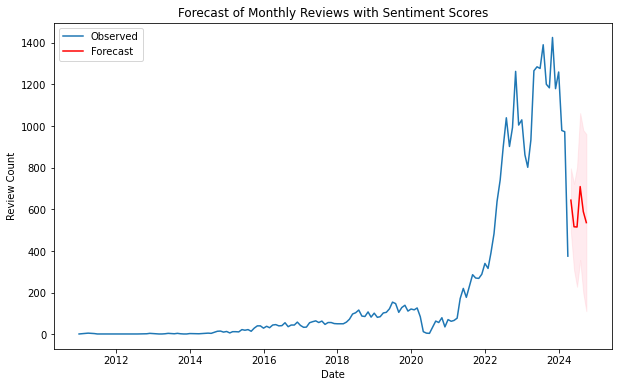

In [40]:
# Forecast the next 6 months
forecast_steps = 6
future_sentiment = combined_df['sentiment_score'].values[-1]  # Using last known sentiment score for future
future_sentiment = np.array([future_sentiment] * forecast_steps).reshape(-1, 1)  # Create future sentiment array

sarimax_forecast = sarimax_fit.get_forecast(steps=forecast_steps, exog=future_sentiment)
sarimax_forecast_mean = sarimax_forecast.predicted_mean
sarimax_forecast_conf_int = sarimax_forecast.conf_int()

# Ensure forecast data are numpy arrays
sarimax_forecast_mean = sarimax_forecast_mean.to_numpy().flatten()
sarimax_forecast_conf_int = sarimax_forecast_conf_int.to_numpy()

# Create forecast index
forecast_index = pd.date_range(start=combined_df.index[-1], periods=forecast_steps + 1, freq='M')[1:]

# Ensure the forecast index is a single-dimensional array
forecast_index = forecast_index.to_numpy()

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(combined_df['review_count'], label='Observed')
plt.plot(forecast_index, sarimax_forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_index, 
                 sarimax_forecast_conf_int[:, 0], 
                 sarimax_forecast_conf_int[:, 1], 
                 color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Review Count')
plt.title('Forecast of Monthly Reviews with Sentiment Scores')
plt.legend()
plt.show()

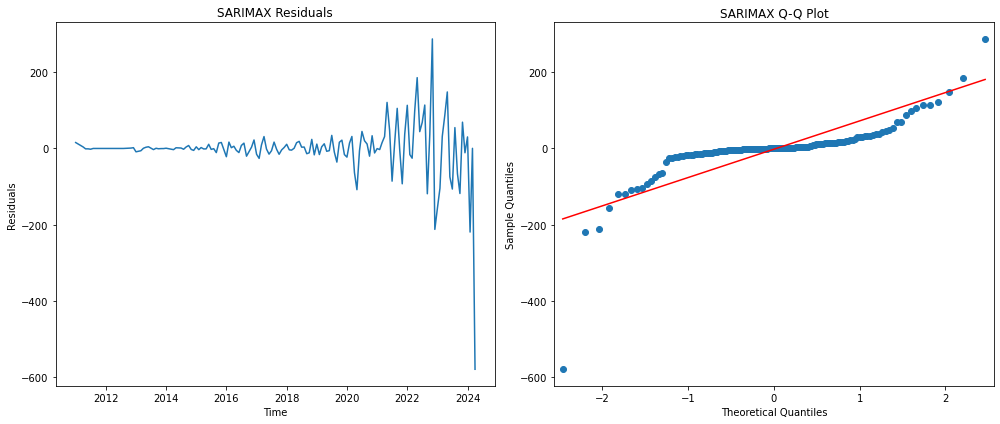

In [43]:
# Residuals Analysis
residuals = sarimax_fit.resid

# Plot the residuals
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Residuals plot
ax[0].plot(residuals)
ax[0].set_title('SARIMAX Residuals')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Residuals')

# Q-Q plot
qqplot(residuals, line='s', ax=ax[1])
ax[1].set_title('SARIMAX Q-Q Plot')

plt.tight_layout()
plt.show()



**How Sentiment is Used in the Forecasting**

1. Sentiment Analysis: Each review was classified into positive, neutral, or negative sentiments using the VADER sentiment analyzer. These classifications were then mapped to numerical scores (positive=1, neutral=0, negative=-1).
2. Sentiment Aggregation: These sentiment scores were aggregated monthly to create a time series of average sentiment scores.
3.SARIMAX Model: The SARIMAX model used the monthly review counts as the dependent variable and the aggregated monthly sentiment scores as an exogenous variable (independent variable). This means the model considered not just the trend and seasonality in the review counts but also the influence of sentiment scores on future review counts.

**Interpretation of the Results**

1. Observed Data: The blue line represents the historical monthly review counts. There is a noticeable increase in review counts starting around 2020, peaking around mid-2023, and then declining towards the end of 2023.
2. Forecasted Data: The red line represents the forecasted review counts for the next six months. The forecast indicates a slight increase in review counts in the immediate future, followed by a slight decline.
3. Confidence Intervals: The shaded pink area around the forecast line represents the 95% confidence interval for the forecasted values. This interval provides a range within which the actual review counts are expected to fall with 95% confidence.

**Implications**

1. Trend and Seasonality: The SARIMAX model has captured the overall trend and seasonality in the review counts. The forecast suggests that the review counts might stabilize around the current level with minor fluctuations.
2. Impact of Sentiment: The sentiment scores have been used to adjust the forecast. If sentiment scores are highly positive, the model might forecast higher review counts, while highly negative sentiment scores could lead to lower forecasted review counts. In this case, the impact of sentiment is reflected in the slight variations in the forecasted values.



### SARIMAX Model Summary and Residuals Analysis ###

**SARIMAX Model Summary:**

1. Model Specification:

The model used is SARIMAX(2, 1, 2)x(1, 1, [1], 12), indicating:
ARIMA(2, 1, 2): Non-seasonal component with:
p=2: Second-order autoregressive term.
d=1: First-order differencing to make the series stationary.
q=2: Second-order moving average term.
Seasonal ARIMA(1, 1, [1], 12): Seasonal component with:
P=1: Seasonal autoregressive term.
D=1: Seasonal differencing term.
Q=1: Seasonal moving average term.
m=12: Seasonal period (monthly seasonality).

2. Coefficients:

sentiment_score: The coefficient for the sentiment score is -14.5319, but it is not significant (p-value = 0.930), suggesting that the sentiment score does not have a strong impact on the review count in this model.
ar.L1: The first-order autoregressive term has a coefficient of -0.0350, which is not significant (p-value = 0.632).
ar.L2: The second-order autoregressive term is significant (p-value = 0.000) with a coefficient of -0.5935, indicating that past values have a significant effect on current values.
ma.L1: The first-order moving average term is not significant (p-value = 0.784).
ma.L2: The second-order moving average term is not significant (p-value = 0.886).
ar.S.L12: The seasonal autoregressive term is not significant (p-value = 0.699).
ma.S.L12: The seasonal moving average term is not significant (p-value = 0.149).
sigma2: The variance of the residuals is 5948.9499, which is quite high but not significant (p-value = 0.885).

3. Model Fit:

Log Likelihood: -760.484.
AIC: 1536.969 (Akaike Information Criterion).
BIC: 1559.970 (Bayesian Information Criterion).
These criteria help in model comparison; lower values generally indicate a better fit.

4. Diagnostic Tests:

Ljung-Box Test:
Q(1): 0.07 with p-value 0.80, indicating that there is no significant autocorrelation in the residuals at lag 1.
Jarque-Bera Test:
JB: 3164.77 with p-value 0.00, indicating that the residuals are not normally distributed.
Heteroskedasticity (H):
H: 246.09 with p-value 0.00, indicating heteroskedasticity in the residuals.
Skew: -2.93, indicating the residuals are left-skewed.
Kurtosis: 26.36, indicating a heavy-tailed distribution of residuals.

**Residuals Analysis:**

1. Residuals Plot:

The residuals plot shows the difference between the observed and fitted values over time. There is significant variability in the residuals, especially towards the end of the time series, which suggests that the model might not be capturing some aspects of the data well.

2. Q-Q Plot:

The Q-Q plot shows that the residuals deviate significantly from the theoretical normal distribution, particularly in the tails. This indicates non-normality in the residuals, which is also supported by the Jarque-Bera test result.

**Model Accuracy**

Accuracy Metrics

1. AIC and BIC:

AIC: 1536.969
BIC: 1559.970
Lower AIC and BIC values indicate a better model fit compared to the first model.

2. Residual Diagnostics:

The Ljung-Box test suggests no significant autocorrelation in residuals at lag 1, which is good.
However, the Jarque-Bera test indicates that the residuals are not normally distributed, and the Q-Q plot confirms this non-normality.
The presence of heteroskedasticity suggests that the variance of residuals is not constant over time, which might affect the model's predictive performance.
